In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from pickle import dump , load
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os

In [2]:
class TaiwaneseCreditClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(23, 64)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(64, 128)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(128, 32)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(32, 16)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(16, 1)
        self.act_output = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(self.act1(self.hidden1(x)))
        x = self.dropout(self.act2(self.hidden2(x)))
        x = self.dropout(self.act3(self.hidden3(x)))
        x = self.dropout(self.act4(self.hidden4(x)))
        # x = self.output(x)
        x = self.act_output(self.output(x))
        return x


def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    accuracy = (y_pred.round() == y_test).float().mean()
    return accuracy

    
def create_and_train_model(X_train, y_train, X_test, y_test, num_epochs, seed):
    torch.manual_seed(seed)
    
    model = TaiwaneseCreditClassifier()
    batch_size = 128
    loss_fn = nn.BCELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.eval()
    accuracy = evaluate(model, X_test, y_test)
    print('accuracy before training {}'.format(accuracy))
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        for i in range(0, len(X_train), batch_size):
            Xbatch = X_train[i:i+batch_size]
            y_pred = model(Xbatch)
            ybatch = y_train[i:i+batch_size]
            loss = loss_fn(y_pred, ybatch)
            # print(loss)
            loss.backward()
            optimizer.step()
        # print(loss.tolist())
        # evaluate model on each epoch
    model.eval()
    accuracy = evaluate(model, X_test, y_test)
    print(f'Finished epoch {epoch},  accuracy {accuracy}')
    return model


def create_data(train_df_loc, test_df_loc, scaler):
    train = pd.read_csv('./../train_balanced.csv')

    test = pd.read_csv('./../test_balanced.csv')
    X_train = train.iloc[:, 0:23].values
    y_train = train.iloc[:, 23].values
    # print(y_train)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    
    X_test = test.iloc[:, 0:23].values
    y_test = test.iloc[:, 23].values
    
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    
    X_train_np = X_train.numpy()
    X_test_np = X_test.numpy()  
    
    X_train_np[:, columns_to_standardize] = scaler.transform(X_train_np[:, columns_to_standardize])
    X_test_np[:, columns_to_standardize] = scaler.transform(X_test_np[:, columns_to_standardize])
    
    # Convert back to PyTorch tensors
    X_train = torch.from_numpy(X_train_np).type(torch.float) 
    X_test = torch.from_numpy(X_test_np).type(torch.float)
    
    return X_train, y_train, X_test, y_test


def create_list_of_model(count, X_train, y_train, X_test, y_test, num_epochs):
    list_of_models = []
    for i in range(count):
        model = create_and_train_model(X_train, y_train, X_test, y_test, num_epochs, i)
        list_of_models.append(model)
    return list_of_models

def load_model():
    model = torch.load('./../model_training/Taiwanese_credit_model')
    model.eval()
    return model

def eval_model(model, input, scaler, columns_to_standardize):
    model.eval()
    # print(input)
    input = input.reshape(-1, 23)
    input = torch.tensor(input, dtype=torch.float32)
    input = input.numpy()
    input[:, columns_to_standardize] = scaler.transform(input[:, columns_to_standardize])
    input = torch.from_numpy(input).type(torch.float)
    with torch.no_grad():
        prob = model(input)
    return prob.tolist()[0][0]

def evaluate_model_for_df(df , model_list, scaler, columns_to_standardize):
    probability_list = []
    if df.shape[0] == 0:
        return 0
    else:
        for index, row in df.iterrows():
            counterfactual_success =[]
            x = row.to_numpy()
            for model in model_list:
                prob = eval_model(model, x, scaler, columns_to_standardize)
                if prob > 0.5:
                    counterfactual_success.append(1)
                else:
                    counterfactual_success.append(0)
            probability_list.append(sum(counterfactual_success)/len(counterfactual_success))
        return sum(probability_list)/len(probability_list)

In [3]:
def calculate_robustness(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, model_list, scaler, columns_to_standardize):
    metric_dict = {'dice_robustness' : [],
                   'Our_method_robustness' : [],
                   'certif_robustness' : [],
                   'GE_NSGAII_robustness': []}
    
    output_dict = {}
        
    for i in os.listdir(input_data_loc):
        if i=='.DS_Store':
            continue
        dice_df = pd.read_csv(dice_loc +  i + '.csv')
        dice_df.drop(columns=['outcome'], inplace=True)
        Our_method_df  = pd.read_csv(ge_cf_loc +  i + '.csv')
        certif_df = pd.read_csv(certif_cf_loc +  i + '.csv')
        NSGAII_df = pd.read_csv(ge_nsga2_loc +  i + '.csv')
        
        
        metric_dict['dice_robustness'].append(evaluate_model_for_df(dice_df, model_list, scaler, columns_to_standardize ))
        metric_dict['Our_method_robustness'].append(evaluate_model_for_df(Our_method_df, model_list, scaler, columns_to_standardize))
        metric_dict['certif_robustness'].append(evaluate_model_for_df(certif_df, model_list, scaler, columns_to_standardize))
        metric_dict['GE_NSGAII_robustness'].append(evaluate_model_for_df(NSGAII_df, model_list, scaler, columns_to_standardize))
    
    for key, value in metric_dict.items():
        output_dict[key] = sum(value)/ len(value)
        
        
    return output_dict, metric_dict


In [4]:
columns_to_standardize = list(range(23))
scaler = load(open('./../model_training/StandardScaler.pkl', 'rb'))
model_orig = load_model()

input_data_loc = './../output/NSGAIII_multi/'
dice_loc = 'Dice_cf/'
ge_cf_loc = 'Ge_cf/'
ge_nsga2_loc = 'Ge_NSGAII_cf/'
certif_cf_loc = 'Certif_cf/'
train_df_loc = "./../train_balanced.csv"
test_df_loc = "./../test_balanced.csv"


In [5]:
X_train, y_train, X_test, y_test = create_data(train_df_loc, test_df_loc, scaler)

In [6]:
list_of_models = create_list_of_model(40, X_train, y_train, X_test, y_test, num_epochs=100)

accuracy before training 0.49679848551750183
Finished epoch 99,  accuracy 0.6779661178588867
accuracy before training 0.5032014846801758
Finished epoch 99,  accuracy 0.6839924454689026
accuracy before training 0.49642184376716614
Finished epoch 99,  accuracy 0.680979311466217
accuracy before training 0.485122412443161
Finished epoch 99,  accuracy 0.6768361330032349
accuracy before training 0.5032014846801758
Finished epoch 99,  accuracy 0.6802259683609009
accuracy before training 0.49679848551750183
Finished epoch 99,  accuracy 0.6824858784675598
accuracy before training 0.4900188446044922
Finished epoch 99,  accuracy 0.6711864471435547
accuracy before training 0.49679848551750183
Finished epoch 99,  accuracy 0.6745762825012207
accuracy before training 0.501694917678833
Finished epoch 99,  accuracy 0.6824858784675598
accuracy before training 0.49679848551750183
Finished epoch 99,  accuracy 0.6866289973258972
accuracy before training 0.538229763507843
Finished epoch 99,  accuracy 0.6824

In [7]:
output_dict, metric_dict = calculate_robustness(input_data_loc, dice_loc, ge_cf_loc, ge_nsga2_loc, certif_cf_loc, list_of_models, scaler, columns_to_standardize)

In [8]:
metric_dict

{'dice_robustness': [0.5881637168141594,
  0.5181297709923666,
  0.5648437499999993,
  0.5739197530864195,
  0.5170903954802258,
  0.5902616279069769,
  0.5173507462686563,
  0.548399390243902,
  0.5366150442477876,
  0.5778431372549014,
  0.5845864661654138,
  0.5795348837209301,
  0.4977011494252876,
  0.11875,
  0.6116564417177912,
  0.5714962121212119,
  0.5365523465703971,
  0.5888528138528136,
  0.5562015503875973,
  0.5959239130434779,
  0.5726141078838175,
  0.5334801762114535,
  0.5343567251461991,
  0.5954285714285715,
  0.5332746478873239,
  0.5692961165048543,
  0.5624999999999998,
  0.5632275132275132,
  0.4706168831168834,
  0.6238636363636364],
 'Our_method_robustness': [0.7183628318584062,
  0.7609732824427476,
  0.8889648437500002,
  0.9058641975308642,
  0.9105932203389825,
  0.9845930232558139,
  0.6672574626865675,
  0.7653201219512196,
  0.6754424778761063,
  0.6818627450980392,
  0.9906015037593985,
  0.8105813953488371,
  0.9885057471264371,
  0.75625,
  0.992024

In [9]:
output_dict

{'dice_robustness': 0.5444177162356857,
 'Our_method_robustness': 0.8417451962401029,
 'certif_robustness': 0.5650042517006804,
 'GE_NSGAII_robustness': 0.8873530538366179}

In [10]:
import matplotlib.pyplot as plt

def plot_bar_graph(data_dict, title="Bar Graph", xlabel="Labels", ylabel="Values"):
    
    labels = list(data_dict.keys())
    values = list(data_dict.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color='skyblue', width=0.4)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

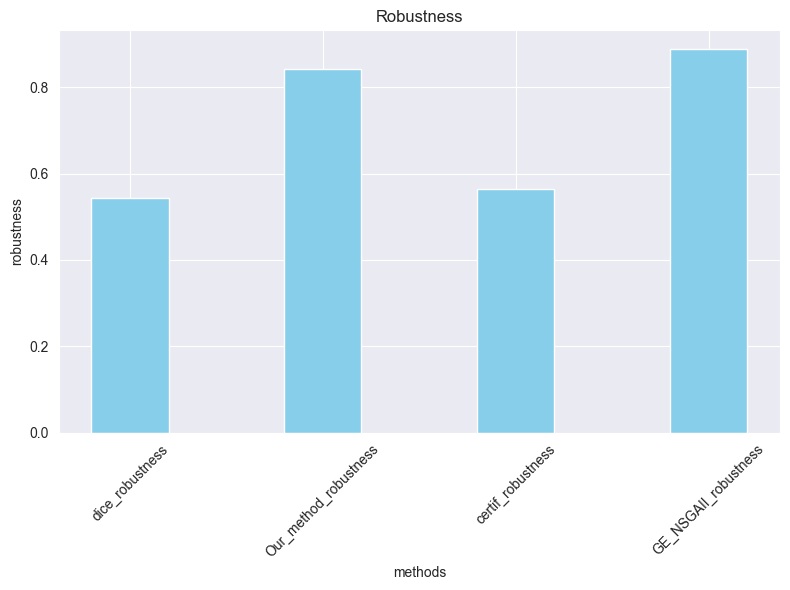

In [11]:
plot_bar_graph(output_dict, title="Robustness", xlabel="methods", ylabel="robustness")